# Guerlédan 2023/10: ctd

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt

import hvplot.pandas # noqa

import pynsitu as pin

In [2]:
root_path = "/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/"

data_files = sorted(glob(os.path.join(root_path, "*.aml")))
data_files

['/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_09-51-12.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_09-56-09.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_12-54-57.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_12-59-49.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_13-02-38.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_13-07-10.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_13-11-03.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_13-14-33.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_13-17-55.aml',
 '/Users/aponte/Current_Projects/ensta/guerledan_202310/data_hydro/aml_log_2023-10-10_13-21

In [47]:
Columns = [
    "date", "time", "battery", 
    "turbidity", "ADC", 
    "wipe", "ADC", 
    "pressure", "ADC", 
    "chloro-blue", "ADC", 
    "conductivity" ,"ADC", 
    "temperature", "ADC", 
    "salinity", "density", "calcSV", "depth",
]
Units = [
    "yyyy-mm-dd", "hh:mm:ss.ss", "V", 
    "NTU", "2sComp", 
    "wipe", "wipe", 
    "dBar", "2sComp", 
    "ug/L", "2sComp", 
    "mS/cm", "none", 
    "C", "none", 
    "PSU", "kg/cm3", "m/s", "m",
]

def read_aml_file(file):

    with open(file) as f:
        lines = f.readlines()

    i=1
    line = lines[0]
    while "[MeasurementData]" not in line:
        line = lines[i].replace("\n", "")
        if 'GPSLatitude' in line:
            lat = float(line.split("=")[1])
        if 'GPSLongitude' in line:
            lon = float(line.split("=")[1])
        i+=1
    
    df = pd.DataFrame([parse_line(line) for line in lines[i:]])
    df = df.loc[df.salinity>0]
    df["latitude"] = lat
    df["longitude"] = lon

    return df

def parse_line(line):
    ls = line.replace("\n","").split(",")
    try:
        d = {**{"time": pd.Timestamp(ls[0]+" "+ls[1])}, 
             **{key: float(value) for key, value in zip(Columns[2:], ls[2:])},
            }
    except:
        print(line)
    #print(line)
    return d
    
def load_descent(file):

    df = read_aml_file(file)

    # select descent
    df = df.loc[
        (df["depth"] < df["depth"].max()-.5)
        & (df["depth"] > .5) 
        & (df.index < df["depth"].idxmax()) 
    ]

    # add descent speed
    dt = df.time.diff() / pd.Timedelta("1s")
    df["speed"] = df.depth.diff()/ dt
    
    return df

In [58]:
D = [load_descent(f) for f in data_files]
# filter out empty dataframes
D = [df for df in D if df.size>0]

# summarize station data in a dataframe
stations = pd.DataFrame([dict(time=df.time.iloc[0], 
                              longitude=df.longitude.iloc[0], latitude=df.latitude.iloc[0],
                              temperature_max=df.temperature.max(),
                             ) for df in D])

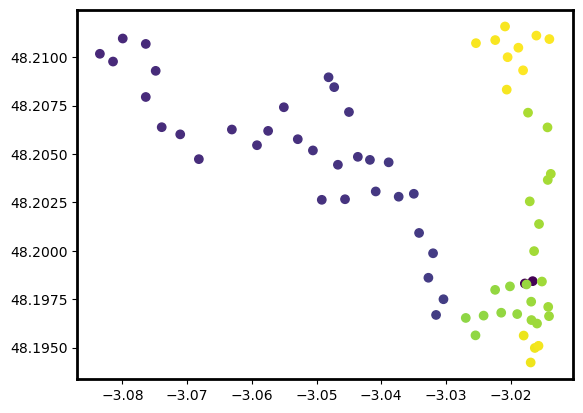

In [59]:
fig, ax = plt.subplots(1,1)
h = ax.scatter(stations.longitude, stations.latitude, c=stations.time)
#fig.colorbar(h)

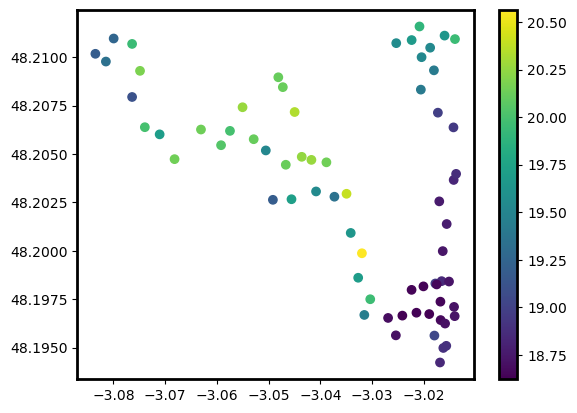

In [61]:
fig, ax = plt.subplots(1,1)
h = ax.scatter(stations.longitude, stations.latitude, c=stations.temperature_max)
fig.colorbar(h)

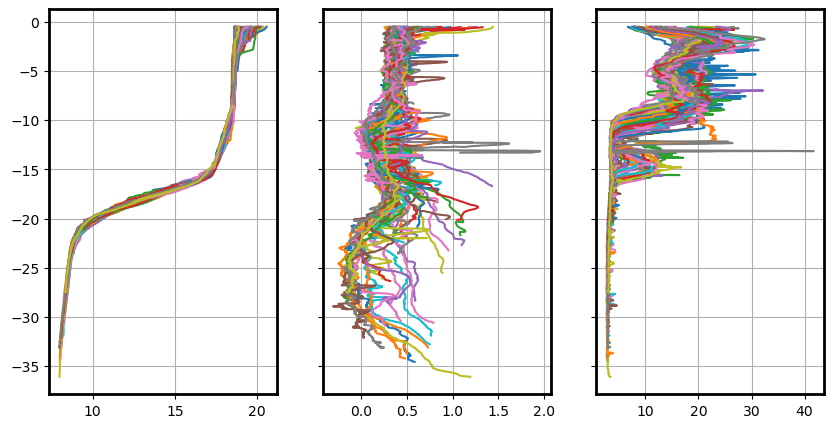

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(10,5), sharey=True)

ax = axes[0]
off = 0
for i, df in enumerate(D):
    ax.plot(df.temperature+i*off, -df.depth)
ax.grid()
    
ax = axes[1]
off = 0
for i, df in enumerate(D):
    ax.plot(np.log10(df.turbidity+i*off), -df.depth)
ax.grid()
    
    
ax = axes[2]
off = 0
for i, df in enumerate(D):
    ax.plot(df["chloro-blue"]+i*off, -df.depth)
ax.grid()

In [69]:
df["depth"].hvplot() * dfd["depth"].hvplot()

:Overlay
   .Curve.Depth.I  :Curve   [index]   (depth)
   .Curve.Depth.II :Curve   [index]   (depth)

<Axes: ylabel='Frequency'>

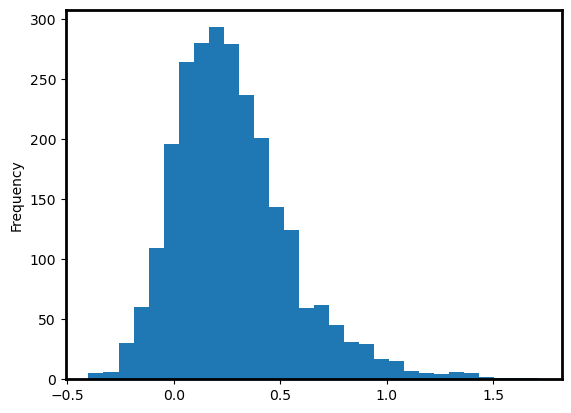

In [62]:
dfd["speed"].plot.hist(bins=30)

In [64]:
import geopandas as gpd

In [ ]:
shp_file = "/Users/aponte/Current_Projects/ensta/guerledan_202310/lacguerledan/LacGuerledan-line.shp"

In [67]:
gdf = gpd.read_file(shp_file) 

<Axes: >

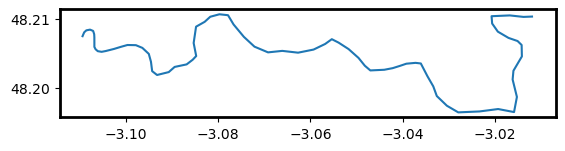

In [68]:
gdf.plot()

In [79]:
s = gdf.iloc[0]

In [84]:
s = gdf.loc[0]
type(s)

pandas.core.series.Series

In [89]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

In [91]:
type(gdf["geometry"])

geopandas.geoseries.GeoSeries

In [92]:
gdf["geometry"].segmentize(max_segment_length=.01)

AttributeError: 'GeoSeries' object has no attribute 'segmentize'

In [95]:
import shapely

In [102]:
type(gdf["geometry"].values[0])

shapely.geometry.linestring.LineString

In [104]:
s = shapely.segmentize(gdf["geometry"].values[0], .01)

In [112]:
gs = gpd.GeoSeries(data=s, crs=gdf.crs)

In [123]:
#for i in s:
#    print(i)

In [120]:
from shapely.geometry import Polygon, LineString, Point

In [122]:
gs.distance(Point(0,0), align=True)

0    48.290822
dtype: float64

In [117]:
s.coords.xy

(array('d', [-3.10945312519977, -3.10901148939415, -3.10854390442596, -3.10774406326615, -3.10706969029824, -3.10684503430336, -3.10680623375381, -3.10680280542879, -3.10680194924097, -3.10654231423014, -3.10606186432, -3.10522988521714, -3.10435757794452, -3.10258544367909, -3.10102952079058, -3.09964746364976, -3.09781704145574, -3.09641246246943, -3.09501451919651, -3.0945455407967, -3.09428893770136, -3.09323380073601, -3.09069916457247, -3.0894184501985, -3.08682141315893, -3.08551329995443, -3.08475164732043, -3.08530333930893, -3.08504212647361, -3.0847810857763, -3.08291993200306, -3.08170378237098, -3.07972034125969, -3.07785890549331, -3.07666128420108, -3.07442398629183, -3.07213020998441, -3.06919177761223, -3.06610450579604, -3.06268685324974, -3.05932958433479, -3.05683052036256, -3.05537963760663, -3.05391282680427, -3.05174725070738, -3.04959790647435, -3.04823129450905, -3.04703781663123, -3.0440161106155, -3.0421961355739, -3.04065908836507, -3.03923099063355, -3.0372

In [109]:
gpd.GeoSeries?

Init signature: gpd.GeoSeries(data=None, index=None, crs=None, **kwargs)
Docstring:     
A Series object designed to store shapely geometry objects.

Parameters
----------
data : array-like, dict, scalar value
    The geometries to store in the GeoSeries.
index : array-like or Index
    The index for the GeoSeries.
crs : value (optional)
    Coordinate Reference System of the geometry objects. Can be anything accepted by
    :meth:`pyproj.CRS.from_user_input() <pyproj.crs.CRS.from_user_input>`,
    such as an authority string (eg "EPSG:4326") or a WKT string.

kwargs
    Additional arguments passed to the Series constructor,
     e.g. ``name``.

Examples
--------

>>> from shapely.geometry import Point
>>> s = geopandas.GeoSeries([Point(1, 1), Point(2, 2), Point(3, 3)])
>>> s
0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

>>> s = geopandas.GeoSeries(
...     [Point(1, 1), Point(2, 2), Point(3, 3)], crs="EPSG:3857"
... )
>>> s.crs

In [106]:
s.line_locate_point?

Signature: s.line_locate_point(other, normalized=False)
Docstring:
Returns the distance along this geometry to a point nearest the
specified point

If the normalized arg is True, return the distance normalized to the
length of the linear geometry.

Alias of `project`.
File:      ~/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/shapely/geometry/base.py
Type:      method

In [ ]:
spah

In [94]:
gpd.__version__

'0.13.2'